In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import numpy_groupies as npg

import scipy as sp
import scipy.signal

import itertools
import string
import pickle
import glob
import os
import re 

import tqdm as tqdm

import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from utils.surf import smooth_adjacent_values
from utils.io import read_seeg_parcel_names
from utils.stats import bootstrap_n_peaks
from utils.vis_3d import BrainSurface
from utils.colors import okabe, subsystem_to_color
from utils.peaks import build_peaks_map, detect_anatomy_peaks
from utils.plot import draw_four_views
from utils.pyutils import get_subsystem
from utils.colors import CmapPruned

%config InlineBackend.figure_format = 'jpg'

d:\Vlad\Anaconda3\envs\seeg_meso_env\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
d:\Vlad\Anaconda3\envs\seeg_meso_env\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=okabe)

In [4]:
def create_subsystem_map(values):
    res = dict()
    
    for v in values:
        if not(v in res):
            res[v] = len(res)
    
    return res

def get_subsystem_hemi(name):
    name = name.split('_')[2]
    
    return name

In [5]:
n_cortical = 400
lags_cycles = np.arange(200)/10

subsystem_to_system = np.array([0, 0, 
                                1, 1, 
                                2, 2, 
                                3, 3, 
                                4, 4, 
                                5, 5,5 ,
                                6,6,6,
                                7])


In [6]:
submission_data_path = os.path.join('..', '..', 'meso_submission_data')
fsaverage_path = os.path.join(submission_data_path, 'anatomy', 'fsaverage')

In [7]:
seeg_parcels_dirpath = os.path.join(submission_data_path, 'SEEG')
seeg_parcel_names = read_seeg_parcel_names(n_cortical, root=seeg_parcels_dirpath)
unk_idx = [idx for (idx, n) in enumerate(seeg_parcel_names[-402:]) if ('unknown' in n.lower()) or ('background' in n.lower())]

cortical_parcels = [n for n in seeg_parcel_names[-402:] if not('unknown' in n.lower() or 'background' in n.lower())]
cortical_subsystems = np.array([get_subsystem_hemi(n) for n in cortical_parcels])

subsystem_to_index = create_subsystem_map(cortical_subsystems)
subsystem_indices = np.array([subsystem_to_index[s] for s in cortical_subsystems])


In [9]:
brain_anatomy = pickle.load(open(os.path.join(submission_data_path, 'anatomy', 'brain_anatomy.pickle'), 'rb'))

brain_surf_lh = brain_anatomy['lh']
brain_surf_rh = brain_anatomy['rh']

surf_parcel_names = brain_surf_lh.parcel_names[1:] + brain_surf_rh.parcel_names[1:]
brain_3d_surfaces = [brain_surf_lh, brain_surf_rh]

In [10]:
yeo17_cmap = plt.get_cmap('tab20c')
yeo17_colors = [yeo17_cmap.colors[subsystem_to_color[get_subsystem(n)]] + (1.0,) for n in surf_parcel_names]
yeo17_tick_labels = ['']*20

for key, value in subsystem_to_color.items():
    yeo17_tick_labels[value] = key

In [11]:
f_vals = [2]

while f_vals[~0] < 99:
    f_vals.append(f_vals[~0]*1.05)

f_vals = np.array(f_vals)

meg_noise_level = np.load(os.path.join(submission_data_path, 'MEG', 'meg_noise_level.npy'))
counter_known = np.load(os.path.join(submission_data_path, 'SEEG', 'counter_known.npy'))
adjacency_matrix = np.load(os.path.join(submission_data_path, 'SEEG', 'adjacency_matrix.npy'))

In [12]:
cortical_peaks_boot = np.load(os.path.join(submission_data_path, 'figure_4', 'seeg_cortical_peaks_boot.npy'))
cortical_peaks_boot_known = np.delete(cortical_peaks_boot[..., -402:], unk_idx, axis=-1)

cortical_peaks_boot_normed = cortical_peaks_boot_known / cortical_peaks_boot_known.sum(axis=1, keepdims=True)
cortical_peaks_boot_system = npg.aggregate(subsystem_indices, cortical_peaks_boot_normed, axis=-1, func='nanmean')

peak_map_normed = np.nanmean(cortical_peaks_boot_normed, axis=0)

C:\Users\vlamyr\AppData\Local\Temp\5\ipykernel_55416\3418871320.py:4: RuntimeWarning: invalid value encountered in true_divide
  cortical_peaks_boot_normed = cortical_peaks_boot_known / cortical_peaks_boot_known.sum(axis=1, keepdims=True)
C:\Users\vlamyr\AppData\Local\Temp\5\ipykernel_55416\3418871320.py:7: RuntimeWarning: Mean of empty slice
  peak_map_normed = np.nanmean(cortical_peaks_boot_normed, axis=0)


In [13]:
seeg_peaks_map = pickle.load(open(os.path.join(submission_data_path, 'figure_4', 'seeg_peaks_map.pickle'), 'rb'))
(single_peaks_map, single_peaks_map_counter, single_peaks_flat), (multi_peaks_map, multi_peaks_map_counter, multi_peaks_flat), (merged_peaks_map, merged_peaks_map_counter, merged_peaks_flat) = seeg_peaks_map

In [14]:
meg_pac_fpath = os.path.join(submission_data_path, 'MEG', 'meg_pac_results_full.pickle')
meg_pac_results = pickle.load(open(meg_pac_fpath, 'rb'))

meg_orig_parcel_names = [n.split('-')[0] for n in meg_pac_results['parcel_names']]
meg_average_pac = meg_pac_results['average_pac']
meg_parcels = [np.arange(400) for _ in range(meg_average_pac.shape[0])]
meg_counter = np.full(counter_known.shape, meg_average_pac.shape[0])

In [15]:
peak_freq_subjects_meg, cortical_peak_map_meg, n_peaks_subjects_meg = detect_anatomy_peaks(meg_average_pac, meg_parcels, meg_noise_level, f_vals)
peak_freq_subjects_meg = peak_freq_subjects_meg[:n_cortical]
cortical_peak_map_meg = cortical_peak_map_meg[..., :n_cortical]

meg_peaks_map = build_peaks_map(peak_freq_subjects_meg, meg_counter, alpha_band=(0,15), beta_band=(15,30))
(single_peaks_map_meg, single_peaks_map_counter_meg, single_peaks_flat_meg), (multi_peaks_map_meg, multi_peaks_map_counter_meg, multi_peaks_flat_meg), (merged_peaks_map_meg, merged_peaks_map_counter_meg, merged_peaks_flat_meg) = meg_peaks_map

In [16]:
meg_to_seeg_idx = [sorted(surf_parcel_names).index(v) for v in surf_parcel_names]

data_parcels_meg = [np.arange(400) for _ in range(len(meg_average_pac))]

peak_map_normed_meg = cortical_peak_map_meg / cortical_peak_map_meg.sum(axis=0, keepdims=True)
peak_map_system_meg = npg.aggregate(subsystem_indices, peak_map_normed_meg, axis=-1, func='nanmean')

cortical_peaks_boot_meg = bootstrap_n_peaks(n_peaks_subjects_meg, data_parcels_meg, n_cortical=n_cortical-93)

cortical_peaks_boot_normed_meg = cortical_peaks_boot_meg / cortical_peaks_boot_meg.sum(axis=1, keepdims=True)
cortical_peaks_boot_system_meg = npg.aggregate(subsystem_indices, cortical_peaks_boot_normed_meg[..., meg_to_seeg_idx], axis=-1, func='nanmean')

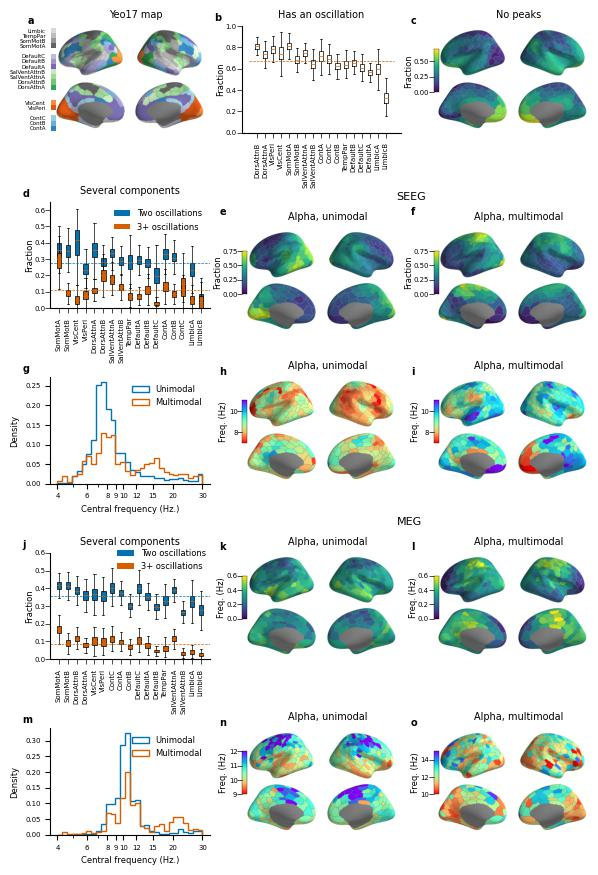

In [17]:
parcels_orig = np.array(list(subsystem_to_index.keys()))
legend_objects = list()

fig = plt.figure(figsize=(7,10.5), dpi=100, constrained_layout=False)
main_spec = fig.add_gridspec(nrows=5, ncols=3, hspace=0.65)

axes = np.empty((10,6), dtype=object)

axes[0,2] = fig.add_subplot(main_spec[0,1])
axes[2,0] = fig.add_subplot(main_spec[1,0])
axes[4,0] = fig.add_subplot(main_spec[2,0])
axes[6,0] = fig.add_subplot(main_spec[3,0])
axes[8,0] = fig.add_subplot(main_spec[4,0])


for i, j in itertools.product([0], [0,2]):
    brain_gs = main_spec[i,j].subgridspec(2,2, wspace=0, hspace=0)
    for nr, nc in itertools.product(range(2), range(2)):
        axes[i*2+nr, j*2+nc] = fig.add_subplot(brain_gs[nr,nc])

for i, j in itertools.product(range(1,5), range(1,3)):
    brain_gs = main_spec[i,j].subgridspec(2,2, wspace=0, hspace=0)
    for nr, nc in itertools.product(range(2), range(2)):
        axes[i*2+nr, j*2+nc] = fig.add_subplot(brain_gs[nr,nc])

for i, (ax, title) in enumerate(zip([axes[0,2], axes[2,0], axes[2,0]], 
                                    ['Has an oscillation', 
                                     'Several components',
                                     'Several components'])):
    if i == 0: # has at least one oscillation
        values = cortical_peaks_boot_system[:, 1:].sum(axis=1)  
        system_mean = npg.aggregate(subsystem_to_system, values.mean(axis=0), func='mean')[subsystem_to_system]
        sorting_values = list(zip(system_mean, values.mean(axis=0)))
        sorted_values = sorted(enumerate(sorting_values), key=lambda x: x[1], reverse=True)

        idx_sorted = [v[0] for v in sorted_values]
    elif i == 1: #has just two oscillations
        values = cortical_peaks_boot_system[:, 2]/cortical_peaks_boot_system[:, 1:].sum(axis=1)

        system_mean = npg.aggregate(subsystem_to_system, values.mean(axis=0), func='mean')[subsystem_to_system]
        sorting_values = list(zip(system_mean, values.mean(axis=0)))
        sorted_values = sorted(enumerate(sorting_values), key=lambda x: x[1], reverse=True)

        idx_sorted = [v[0] for v in sorted_values]
    else: # has 3+ oscillations
        values = cortical_peaks_boot_system[:, 3:].sum(axis=1)/cortical_peaks_boot_system[:, 1:].sum(axis=1)
    
    bp = ax.boxplot(values[:, idx_sorted], showfliers=False, labels=parcels_orig[idx_sorted], patch_artist=bool(i), 
                    boxprops={'linewidth':0.5}, whiskerprops={'linewidth':0.5}, medianprops={'linewidth':0.5}, capprops={'linewidth':0.5})

    mean_color = okabe[0] if i == 1 else okabe[1] 
    ax.hlines(values.mean(), 0, 18, ls='--', lw=0.5, color=mean_color)
    
    if i in (0,1):
        ax.set_title(title, fontsize=7)

        ax.set_ylim([0,1])
        ax.tick_params(axis='x', rotation=90, labelsize=5, width=0.5)
        ax.tick_params(axis='y', labelsize=5, width=0.5, pad=0.1)
        
    if i == 1:
        ax.set_xticks([])
        ax.set_xticklabels([])
        
    if i in (1,2):
        legend_objects.append(bp['boxes'][0])
        
        color = okabe[0] if i == 1 else okabe[1]
        for patch in bp['boxes']:
            patch.set_facecolor(color)
            
    ax.set_ylabel('Fraction', fontsize=6, labelpad=0)

         
axes[4, 0].hist(single_peaks_flat, bins=np.geomspace(4,30,31), density=True, histtype='step', label='Unimodal')
axes[4, 0].hist(multi_peaks_flat, bins=np.geomspace(4,30,31), density=True, histtype='step', label='Multimodal')


for i, (ax, title) in enumerate(zip([axes[6,0], axes[6,0]], 
                                    ['Several components',
                                     'Several components'])):
    if i == 0: #has just two oscillations
        values = cortical_peaks_boot_system_meg[:, 2]/cortical_peaks_boot_system_meg[:, 1:].sum(axis=1)

        system_mean = npg.aggregate(subsystem_to_system, values.mean(axis=0), func='mean')[subsystem_to_system]
        sorting_values = list(zip(system_mean, values.mean(axis=0)))
        sorted_values = sorted(enumerate(sorting_values), key=lambda x: x[1], reverse=True)

        idx_sorted = [v[0] for v in sorted_values]
    else: # has 3+ oscillations
        values = cortical_peaks_boot_system_meg[:, 3:].sum(axis=1)/cortical_peaks_boot_system_meg[:, 1:].sum(axis=1)
    
    bp = ax.boxplot(values[:, idx_sorted], showfliers=False, labels=parcels_orig[idx_sorted], patch_artist=True, 
                    boxprops={'linewidth':0.5}, whiskerprops={'linewidth':0.5}, medianprops={'linewidth':0.5}, capprops={'linewidth':0.5})

    mean_color = okabe[0] if i == 0 else okabe[1] 
    ax.hlines(values.mean(), 0, 18, ls='--', lw=0.5, color=mean_color)
    
    if i in (0,1):
        ax.set_title(title, fontsize=7)

        ax.set_ylim([0,1])
        ax.tick_params(axis='x', rotation=90, labelsize=5, width=0.5)
        ax.tick_params(axis='y', labelsize=5, width=0.5, pad=0.1)
        
    if i == 0:
        ax.set_xticks([])
        ax.set_xticklabels([])
        
    if i in (0,1):
        legend_objects.append(bp['boxes'][0])
        
        color = okabe[0] if i == 0 else okabe[1]
        for patch in bp['boxes']:
            patch.set_facecolor(color)
            
    ax.set_ylabel('Fraction', fontsize=6, labelpad=0)

legend_elements = [Patch(facecolor=okabe[0], label='Two oscillations'),
                   Patch(facecolor=okabe[1], label='3+ oscillations')]

axes[2,0].legend(handles=legend_elements, frameon=False, fontsize=6)
axes[6,0].legend(handles=legend_elements, frameon=False, fontsize=6, loc=(0.4, 0.8))

axes[8, 0].hist(single_peaks_flat_meg, bins=np.geomspace(4,30,31), density=True, histtype='step', label='Unimodal')
axes[8, 0].hist(multi_peaks_flat_meg, bins=np.geomspace(4,30,31), density=True, histtype='step', label='Multimodal')


for ax in [axes[4,0], axes[8,0]]:
    ax.set_xscale('log')

    ax.xaxis.set_minor_formatter(mticker.NullFormatter())
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())

    ax.set_xlabel('Central frequency (Hz.)', fontsize=6)
    ax.set_ylabel('Density', fontsize=6)
    ax.tick_params(labelsize=5, axis='both')
    ax.legend(fontsize=6, frameon=False)

    ax.set_xticks([4,6,8,9,10,12,15,20,30])
    

values = smooth_adjacent_values(peak_map_normed[0], counter_known, adjacency_matrix)
draw_four_views(axes[0:2, 4:6], values, surf_parcel_names, brain_3d_surfaces, title_kwargs={'fontsize': 7},
                cmap='viridis', title='No peaks', norm_values=[0.0, 0.7])


# SEEG PREVALENCE

values =  single_peaks_map_counter[:,0].copy()
values = smooth_adjacent_values(values, single_peaks_map_counter[:,0], adjacency_matrix, replace_na=True)
norm_values = [0,.75]

draw_four_views(axes[2:4, 2:4], values, surf_parcel_names, brain_3d_surfaces, title_kwargs={'fontsize': 7},
                cmap='viridis', title='Alpha, unimodal', norm_values=norm_values)

values =  multi_peaks_map_counter[:,0].copy()
values = smooth_adjacent_values(values, multi_peaks_map_counter[:,0], adjacency_matrix, replace_na=True)

draw_four_views(axes[2:4, 4:6], values, surf_parcel_names, brain_3d_surfaces, title_kwargs={'fontsize': 7},
                cmap='viridis', title='Alpha, multimodal', norm_values=norm_values)

# SEEG FREQS

values =  single_peaks_map[:,0].copy()
values = smooth_adjacent_values(values, single_peaks_map_counter[:,0], adjacency_matrix, replace_na=True)


norm_values = [7,11]

draw_four_views(axes[4:6, 2:4], values, surf_parcel_names, brain_3d_surfaces, title_kwargs={'fontsize': 7},
                cmap='rainbow_r', title='Alpha, unimodal', norm_values=norm_values)

values =  multi_peaks_map[:,0].copy()
values = smooth_adjacent_values(values, multi_peaks_map_counter[:,0], adjacency_matrix, replace_na=True)

draw_four_views(axes[4:6, 4:6], values, surf_parcel_names, brain_3d_surfaces, title_kwargs={'fontsize': 7},
                cmap='rainbow_r', title='Alpha, multimodal', norm_values=norm_values)

# MEG PREVALENCE

values =  single_peaks_map_counter_meg[:,0].copy()
norm_values = [0,.6]

draw_four_views(axes[6:8, 2:4], values[np.argsort(meg_pac_results['parcel_names'])], sorted(surf_parcel_names), brain_3d_surfaces, title_kwargs={'fontsize': 7},
                cmap='viridis', title='Alpha, unimodal', norm_values=norm_values)

values =  multi_peaks_map_counter_meg[:,0].copy()

draw_four_views(axes[6:8, 4:6], values[np.argsort(meg_pac_results['parcel_names'])], sorted(surf_parcel_names), brain_3d_surfaces, title_kwargs={'fontsize': 7},
                cmap='viridis', title='Alpha, multimodal', norm_values=norm_values)


# MEG FREQS

values =  single_peaks_map_meg[:,0].copy()
norm_values = [9.0, 12.0]


draw_four_views(axes[8:10, 2:4], values[meg_to_seeg_idx], surf_parcel_names, brain_3d_surfaces, title_kwargs={'fontsize': 7},
                cmap='rainbow_r', title='Alpha, unimodal', norm_values=norm_values)

values =  multi_peaks_map_meg[:,0].copy()
norm_values = [10.0, 15.0]
draw_four_views(axes[8:10, 4:6], values[meg_to_seeg_idx], surf_parcel_names, brain_3d_surfaces, title_kwargs={'fontsize': 7},
                cmap='rainbow_r', title='Alpha, multimodal', norm_values=norm_values)

# YEO 17

draw_four_views(axes[:2,:2], yeo17_colors, surf_parcel_names, brain_3d_surfaces, title_kwargs={'fontsize': 7},
                cmap='viridis', title='Yeo17 map', norm_values=[0.0, 0.7], cbar_ax_kwargs={'height': '125%', 'bbox_to_anchor': (-0.15,0.55,0.7,1.55)})

custom_cmap = CmapPruned(plt.get_cmap('tab20c'), prune_idx=[3,6,7,15])

cb = mpl.colorbar.ColorbarBase(fig.axes[~0], cmap=custom_cmap, norm=mpl.colors.Normalize(0,20), drawedges=False)

fig.axes[~0].set_yticks(np.arange(20)+0.5)
fig.axes[~0].set_yticklabels(yeo17_tick_labels)
fig.axes[~0].yaxis.set_ticks_position('left')

fig.axes[~0].tick_params(left=False, labelsize=4, pad=0, width=0.5)
cb.outline.set_visible(False)

for ax in axes[2:4, 2:6].flatten():
    bb = list(ax.get_position().bounds)
    bb[1] -= 0.025

    ax.set_position(bb)

for ax in [axes[0, 2], axes[2,0], axes[4,0], axes[6,0], axes[8,0]]: 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


axes[2,0].set_ylim([0,0.65])
axes[6,0].set_ylim([0,0.6])

axes[2,0].set_xlim([0,18])
axes[6,0].set_xlim([0,18])


for ax, ylabel in zip(fig.axes[-10:-1], ['Fraction']*3 + ['Freq. (Hz)']*6):
    ax.yaxis.set_tick_params(labelsize=5, pad=0, width=0.5) 
    ax.set_ylabel(ylabel, fontsize=6, labelpad=0.25)
    ax.yaxis.set_label_position('left')

brain_ax_labels = [axes[0,0], axes[0,4], axes[4,2], axes[4,4], axes[6,2], axes[6,4], axes[8,2], axes[8,4]]
brain_moved_ax_labels = [axes[2,2], axes[2,4]]
ax_labels = [axes[0,2], axes[2,0], axes[4,0], axes[6,0],  axes[8,0]]

fig.text(0.62, 0.715, 'SEEG', fontsize=8)
fig.text(0.62, 0.405, 'MEG', fontsize=8)

for ax, label in zip(brain_ax_labels, 'achiklno'):
    ax.text(-0.375, 1.05, label, fontsize=7, transform=ax.transAxes, weight='bold')

for ax, label in zip(brain_moved_ax_labels, 'ef'):
    ax.text(-0.375, 1.25, label, fontsize=7, transform=ax.transAxes, weight='bold')

for ax, label in zip(ax_labels, 'bdgjm'):
    ax.text(-0.175, 1.05, label, fontsize=7, transform=ax.transAxes, weight='bold')
    
fig.savefig('publication_figures/figure_4.png', dpi=300, bbox_inches="tight")

for format in ['svg', 'pdf']:
    fig.savefig(f'publication_figures_vector/figure_4.{format}', dpi=300, bbox_inches="tight")

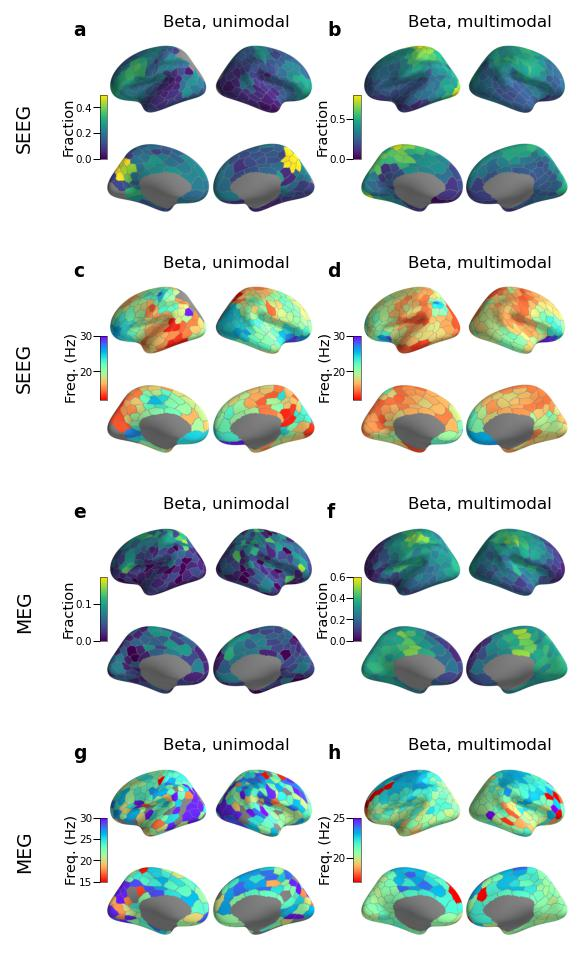

In [18]:
fig = plt.figure(figsize=(4,8), dpi=150, constrained_layout=False)
main_spec = fig.add_gridspec(nrows=4, ncols=2)

axes = np.empty((8,4), dtype=object)

for i, j in itertools.product(range(4), range(2)):
    brain_gs = main_spec[i,j].subgridspec(2,2, wspace=0, hspace=0)
    for nr, nc in itertools.product(range(2), range(2)):
        axes[i*2+nr, j*2+nc] = fig.add_subplot(brain_gs[nr,nc])


# SEEG PREVALENCE

values = single_peaks_map_counter[:,1].copy()
values = smooth_adjacent_values(values, single_peaks_map_counter[:,1], adjacency_matrix, replace_na=True)
norm_values = [0, 0.5]

draw_four_views(axes[0:2, 0:2], values, surf_parcel_names, brain_3d_surfaces, title_kwargs={'fontsize': 8},
                cmap='viridis', title='Beta, unimodal', norm_values=norm_values)

values =  multi_peaks_map_counter[:,1].copy()
values = smooth_adjacent_values(values, multi_peaks_map_counter[:,1], adjacency_matrix, replace_na=True)

norm_values = [0, 0.8]

draw_four_views(axes[0:2, 2:4], values, surf_parcel_names, brain_3d_surfaces, title_kwargs={'fontsize': 8},
                cmap='viridis', title='Beta, multimodal', norm_values=norm_values)

# SEEG FREQS

values =  single_peaks_map[:,1].copy()
values = smooth_adjacent_values(values, single_peaks_map_counter[:,1], adjacency_matrix, replace_na=True)


norm_values = [12.0, 30.0]

draw_four_views(axes[2:4, 0:2], values, surf_parcel_names, brain_3d_surfaces, title_kwargs={'fontsize': 8},
                cmap='rainbow_r', title='Beta, unimodal', norm_values=norm_values)

values =  multi_peaks_map[:,1].copy()
values = smooth_adjacent_values(values, multi_peaks_map_counter[:,1], adjacency_matrix, replace_na=True)

draw_four_views(axes[2:4, 2:4], values, surf_parcel_names, brain_3d_surfaces, title_kwargs={'fontsize': 8},
                cmap='rainbow_r', title='Beta, multimodal', norm_values=norm_values)

# MEG PREVALENCE

values =  single_peaks_map_counter_meg[:,1].copy()
norm_values = [0, 0.175]

draw_four_views(axes[4:6, 0:2], values[np.argsort(meg_pac_results['parcel_names'])], sorted(surf_parcel_names), brain_3d_surfaces, title_kwargs={'fontsize': 8},
                cmap='viridis', title='Beta, unimodal', norm_values=norm_values)

values =  multi_peaks_map_counter_meg[:,1].copy()
norm_values = [0, 0.6]

draw_four_views(axes[4:6, 2:4], values[np.argsort(meg_pac_results['parcel_names'])], sorted(surf_parcel_names), brain_3d_surfaces, title_kwargs={'fontsize': 8},
                cmap='viridis', title='Beta, multimodal', norm_values=norm_values)


# MEG FREQS

values =  single_peaks_map_meg[:,1].copy()
norm_values = [15.0, 30.0]


draw_four_views(axes[6:8, 0:2], values[meg_to_seeg_idx], surf_parcel_names, brain_3d_surfaces, title_kwargs={'fontsize': 8},
                cmap='rainbow_r', title='Beta, unimodal', norm_values=norm_values)


values =  multi_peaks_map_meg[:,1].copy()
norm_values = [17.0, 25.0]

draw_four_views(axes[6:8, 2:4], values[meg_to_seeg_idx], surf_parcel_names, brain_3d_surfaces, title_kwargs={'fontsize': 8},
                cmap='rainbow_r', title='Beta, multimodal', norm_values=norm_values)


for ax, ylabel in zip(fig.axes[-8:], ['Fraction']*2 + ['Freq. (Hz)']*2 + ['Fraction']*2 + ['Freq. (Hz)']*2):
    ax.yaxis.set_tick_params(labelsize=5, pad=0, width=0.5) 
    ax.set_ylabel(ylabel, fontsize=7, labelpad=0.0)
    ax.yaxis.set_label_position('left')


ax_labels = [axes[0,0], axes[0,2], axes[2,0], axes[2,2], axes[4,0], axes[4,2], axes[6,0], axes[6,2]]
for ax, label in zip(ax_labels, string.ascii_lowercase):
    ax.text(-0.3, 1.05, label, fontsize=9, transform=ax.transAxes, weight='bold')

for ypos, label in zip([0.18, 0.38, 0.58, 0.78], ['MEG' , 'MEG', 'SEEG', 'SEEG']):
    fig.text(-0.025, ypos, label, rotation=90, fontsize=9)

fig.savefig('publication_figures/figure_4_supp.png', dpi=300, bbox_inches="tight")